### 1. Importing the Libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARMA
register_matplotlib_converters()
from time import time

### 2. Loadting the Dataset and Parsing the Dates 

In [2]:
# We use parser module to convert date column to datetime format.
def parser(s):
    return datetime.strptime(s, '%d/%m/%Y')

In [3]:
data = pd.read_csv('testsdata.csv',parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [4]:
data

From Date
2018-04-24    31.88
2018-04-25    46.02
2018-04-26    53.51
2018-04-27    44.98
2018-04-28    50.21
              ...  
2020-03-20    26.85
2020-03-21    25.95
2020-03-22    27.73
2020-03-23     30.1
2020-03-24     32.4
Name: PM2.5, Length: 701, dtype: object

### 3. Dealing with Missing Values 

In [5]:
# Converting values marked 'None' to NaN.
data = data.replace('None', np.nan)

In [6]:
# The datatype was object, so converted it to floating point number. 
data = pd.to_numeric(data)

In [7]:
#Identifying the total number of missing values 
data.isnull().sum()

20

In [8]:
#Replacing the missing values with the nearest values.
data =data.interpolate(method = 'nearest')

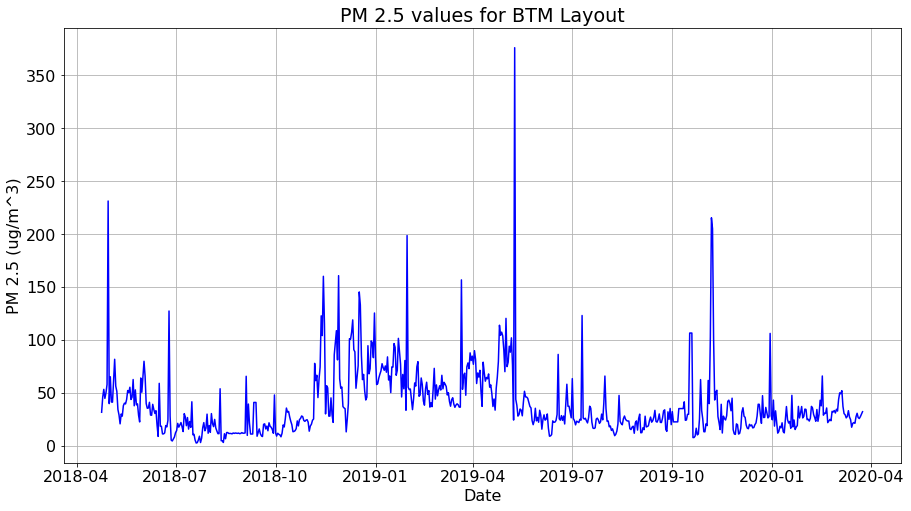

In [19]:
# data visualization
plt.rcParams.update({'font.size': 16})
plt.figure(figsize = (15,8))
plt.plot(data, color = 'black')
plt.xlabel('Date')
plt.ylabel('PM 2.5 (ug/m^3)')
plt.title('PM 2.5 values for BTM Layout')
plt.grid(True)

### 4. Dealing with Outliers

In [23]:
# Finding Upper Quartile using Inter Quartile Range(IQR)
Q1 = np.quantile(data,0.25)
Q3 = np.quantile(data,0.75)
IQR = Q3 - Q1
upper_lim = Q3 + 1.5* IQR
upper_lim

95.405

In [24]:
for i in range(len(data)):
    if data[i] > upper_lim:
        data = data.replace(data[i], data.mean())

In [25]:
data

From Date
2018-04-24    31.88
2018-04-25    46.02
2018-04-26    53.51
2018-04-27    44.98
2018-04-28    50.21
              ...  
2020-03-20    26.85
2020-03-21    25.95
2020-03-22    27.73
2020-03-23    30.10
2020-03-24    32.40
Name: PM2.5, Length: 701, dtype: float64

### 4. Data Visualization

(0.0, 150.0)

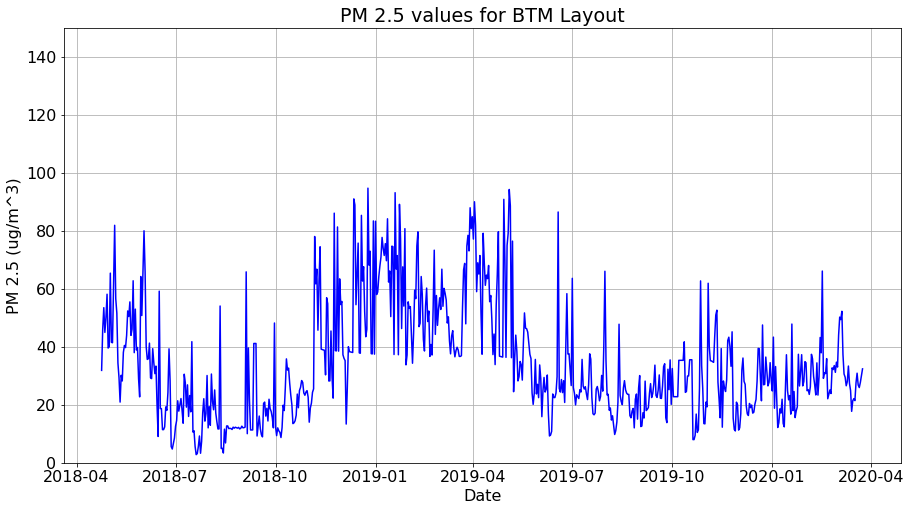

In [31]:
# data visualization
plt.rcParams.update({'font.size': 16})
plt.figure(figsize = (15,8))
plt.plot(data, color = 'black')
plt.xlabel('Date')
plt.ylabel('PM 2.5 (ug/m^3)')
plt.title('PM 2.5 values for BTM Layout')
plt.grid(True)
plt.ylim((0,150))

### 5. Checking Stationarity of Data
#### 5.1 Seasonal Decomposition

<ipython-input-34-e8b425ce1ed4>:4: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(data[:], model='additive', freq=30)


<Figure size 1152x576 with 0 Axes>

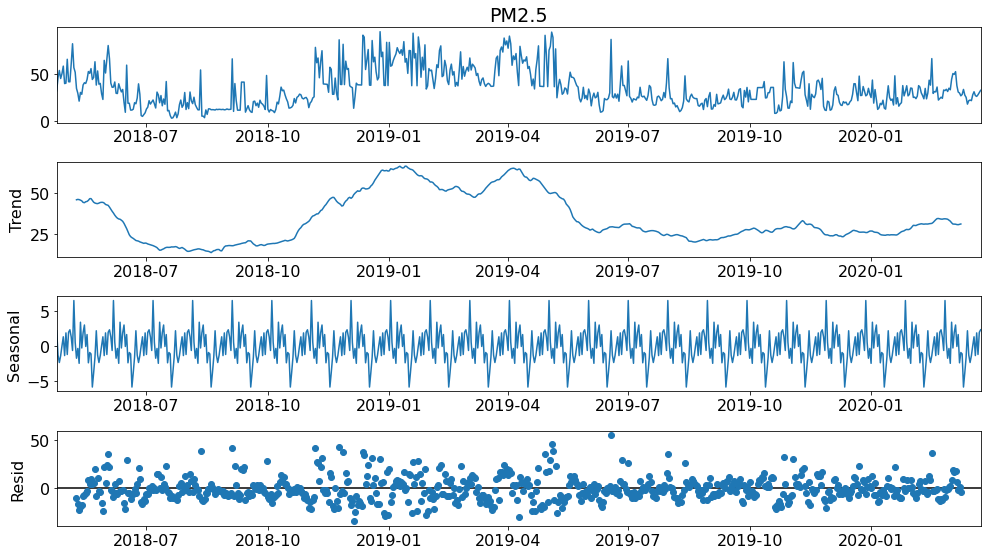

In [34]:
#Seasonal Decomposition Plot
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data[:], model='additive', freq=30)
plt.figure(figsize=(16,8))
fig = result.plot()
plt.show()

#### 5.2 ACF and PACF Plots

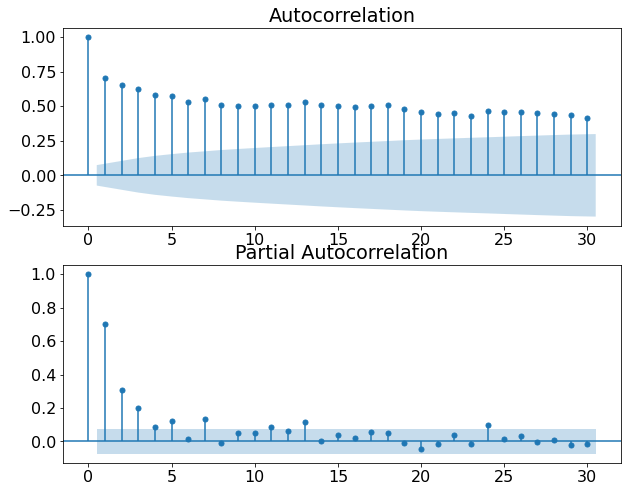

In [41]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
pyplot.figure(figsize =(10,8))
pyplot.subplot(211)
plot_acf(data, ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
plot_pacf(data, ax=pyplot.gca(), lags = 30)
pyplot.show()
#acf_vals = acf(data)
#plt.bar(range(10), acf_vals[:10])

#### 5.3. ADF Test for Stationarity

In [42]:
from statsmodels.tsa.stattools import adfuller
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [43]:
perform_adf_test(data)

ADF Statistic: -2.655981
p-value: 0.081970


### 6. Making the Data Stationary

In [44]:
# We will use first order differencing
data['Diff1']= data.diff(periods = 1)
data['Diff1']

From Date
2018-04-24      NaN
2018-04-25    14.14
2018-04-26     7.49
2018-04-27    -8.53
2018-04-28     5.23
              ...  
2020-03-20    -4.06
2020-03-21    -0.90
2020-03-22     1.78
2020-03-23     2.37
2020-03-24     2.30
Name: PM2.5, Length: 701, dtype: float64

In [45]:
# Removing NaN data
data['Diff1'] = data['Diff1'][1:]
data['Diff1']

From Date
2018-04-25    14.14
2018-04-26     7.49
2018-04-27    -8.53
2018-04-28     5.23
2018-04-29     7.94
              ...  
2020-03-20    -4.06
2020-03-21    -0.90
2020-03-22     1.78
2020-03-23     2.37
2020-03-24     2.30
Name: PM2.5, Length: 700, dtype: float64

(-100.0, 100.0)

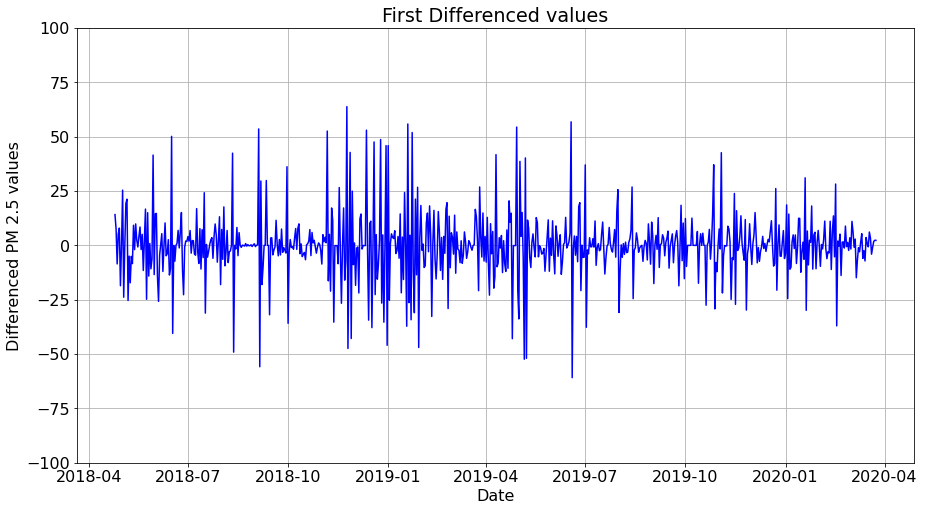

In [46]:
plt.figure(figsize = (15,8))
plt.plot(data['Diff1'], color = 'black')
plt.xlabel('Date')
plt.ylabel('Differenced PM 2.5 values')
plt.title('First Differenced values')
plt.grid(True)
plt.ylim((-100,100))

In [51]:
perform_adf_test(data['Diff1'])

ADF Statistic: -12.623718
p-value: 0.000000


### 7. Dividing Data into Train and Validation Set

In [52]:
#divide into train and validation set. Here, we use 7 days for validation because it is more suited to short term forecasting
train = data['Diff1'][:int(len(data['Diff1']))-7]
valid = data['Diff1'][int(len(data['Diff1']))-7:]

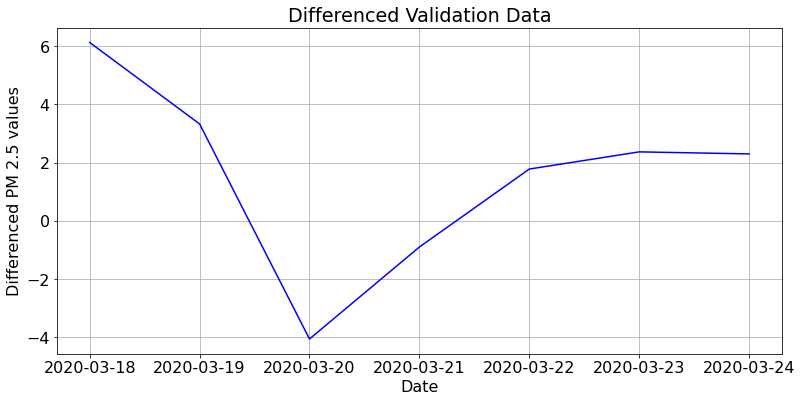

In [56]:
#Plotting the validation data
plt.figure(figsize = (13,6))
plt.plot(valid, color = 'b')
plt.xlabel('Date')
plt.ylabel('Differenced PM 2.5 values')
plt.title('Differenced Validation Data')
plt.grid(True)

In [57]:
valid

From Date
2020-03-18    6.13
2020-03-19    3.33
2020-03-20   -4.06
2020-03-21   -0.90
2020-03-22    1.78
2020-03-23    2.37
2020-03-24    2.30
Name: PM2.5, dtype: float64

### 8. Fitting the AR Model

In [58]:
#Importing autoregression module
from statsmodels.tsa.ar_model import AutoReg
import warnings
warnings.filterwarnings("ignore")

In [60]:
#choosing best fit using AICc criterion 
for _ in range(1,25):
    ar_model = AutoReg(train, lags=_).fit()
    print("Lag = %f AIC = %f BIC = %f" %(_,ar_model.aic, ar_model.bic))

Lag = 1.000000 AIC = 5.262768 BIC = 5.282448
Lag = 2.000000 AIC = 5.198060 BIC = 5.224330
Lag = 3.000000 AIC = 5.185196 BIC = 5.218070
Lag = 4.000000 AIC = 5.165475 BIC = 5.204969
Lag = 5.000000 AIC = 5.166924 BIC = 5.213052
Lag = 6.000000 AIC = 5.145797 BIC = 5.198575
Lag = 7.000000 AIC = 5.149893 BIC = 5.209336
Lag = 8.000000 AIC = 5.144894 BIC = 5.211017
Lag = 9.000000 AIC = 5.143728 BIC = 5.216546
Lag = 10.000000 AIC = 5.137564 BIC = 5.217093
Lag = 11.000000 AIC = 5.134237 BIC = 5.220492
Lag = 12.000000 AIC = 5.113787 BIC = 5.206783
Lag = 13.000000 AIC = 5.117901 BIC = 5.217653
Lag = 14.000000 AIC = 5.120098 BIC = 5.226622
Lag = 15.000000 AIC = 5.119205 BIC = 5.232517
Lag = 16.000000 AIC = 5.117665 BIC = 5.237781
Lag = 17.000000 AIC = 5.115385 BIC = 5.242319
Lag = 18.000000 AIC = 5.119819 BIC = 5.253588
Lag = 19.000000 AIC = 5.121804 BIC = 5.262424
Lag = 20.000000 AIC = 5.125910 BIC = 5.273396
Lag = 21.000000 AIC = 5.128977 BIC = 5.283346
Lag = 22.000000 AIC = 5.133320 BIC = 5.2945

In [61]:
# Minimum AIC and BIC value is for lag = 12 therefore we choose lag = 12
ar_model = AutoReg(train, lags=12).fit()
print(ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:                  PM2.5   No. Observations:                  693
Model:                    AutoReg(12)   Log Likelihood               -2693.542
Method:               Conditional MLE   S.D. of innovations             12.633
Date:                Wed, 29 Sep 2021   AIC                              5.114
Time:                        01:00:45   BIC                              5.207
Sample:                    05-07-2018   HQIC                             5.150
                         - 03-17-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1992      0.484     -0.411      0.681      -1.148       0.750
PM2.5.L1      -0.6143      0.038    -16.231      0.000      -0.689      -0.540
PM2.5.L2      -0.4592      0.044    -10.430      0.0

(-100.0, 100.0)

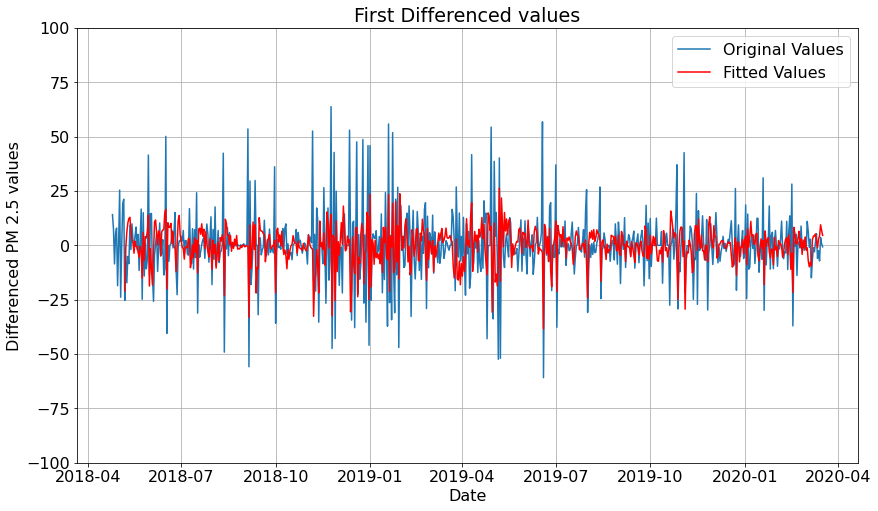

In [62]:
#visualizing the fitted values 
plt.plot(train, label='Original Values')
plt.plot(ar_model.fittedvalues, color='red', label='Fitted Values')
plt.xlabel('Date')
plt.ylabel('Differenced PM 2.5 values')
plt.title('First Differenced values')
plt.grid(True)
plt.legend()
plt.ylim((-100,100))

### 9. Making Predictions 

In [63]:
#Making 7 Day forecast
forecast = ar_model.predict(start = len(train), end = len(train)+6)
forecast

2020-03-18    5.757697
2020-03-19   -1.403131
2020-03-20    0.123912
2020-03-21   -0.579501
2020-03-22    0.313248
2020-03-23    0.485978
2020-03-24    0.032443
Freq: D, dtype: float64

In [64]:
valid

From Date
2020-03-18    6.13
2020-03-19    3.33
2020-03-20   -4.06
2020-03-21   -0.90
2020-03-22    1.78
2020-03-23    2.37
2020-03-24    2.30
Name: PM2.5, dtype: float64

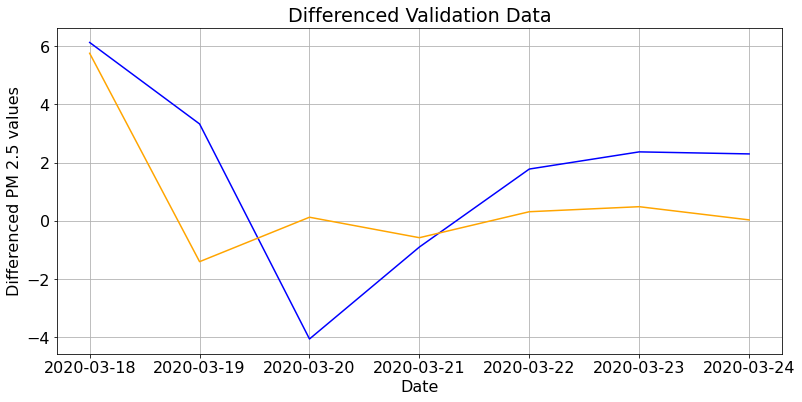

In [65]:
#Plotting the validation data
plt.figure(figsize = (13,6))
plt.plot(valid, label ='Valid', color = 'b')
plt.plot(forecast,label = 'Forecast', color = 'orange')
plt.xlabel('Date')
plt.ylabel('Differenced PM 2.5 values')
plt.title('Differenced Validation Data')
plt.grid(True)

### 10. Converting Data Back to Original Scale

In [66]:
#Converting Differenced data back to Original Scale
data[-9]

21.45

In [67]:
import copy
valid_AR = copy.deepcopy(valid)
valid_AR[0] = valid_AR[0] + data[-9]
for i in range(1,len(valid_AR)):
    valid_AR[i] = valid_AR[i] + valid_AR[i-1]
valid_AR

From Date
2020-03-18    27.58
2020-03-19    30.91
2020-03-20    26.85
2020-03-21    25.95
2020-03-22    27.73
2020-03-23    30.10
2020-03-24    32.40
Name: PM2.5, dtype: float64

In [68]:
#converting forecasts to Oiginal Scale
forecast_AR = copy.deepcopy(forecast)
s = forecast_AR.cumsum()
s = s + data[-9]
s

2020-03-18    27.207697
2020-03-19    25.804566
2020-03-20    25.928479
2020-03-21    25.348978
2020-03-22    25.662226
2020-03-23    26.148204
2020-03-24    26.180646
Freq: D, dtype: float64

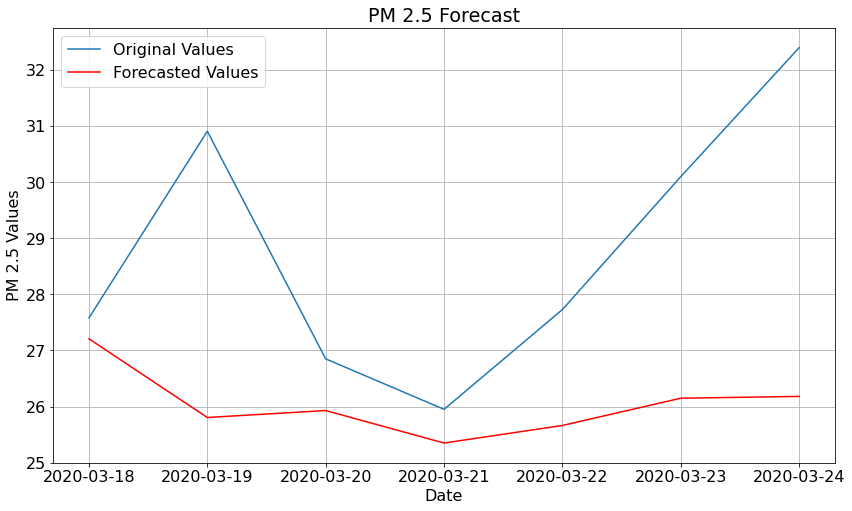

In [70]:
#plotting the results
plt.plot(figsize=(10,5))
plt.plot(valid_AR, label='Original Values')
plt.plot(s, color='red', label='Forecasted Values')
plt.xlabel('Date')
plt.ylabel('PM 2.5 Values')
plt.title('PM 2.5 Forecast')
plt.grid(True)
plt.legend()

### 11. Checking Forecast Accuracy

In [72]:
#Calculating RMS Error
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(valid_AR, s))
rms

3.5048382205285913

In [73]:
#Calculating MAPE
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape
MAPE(valid_AR, s)

9.056631620434983

### 12. Checking Residuals 

In [77]:
residuals = valid - forecast_AR

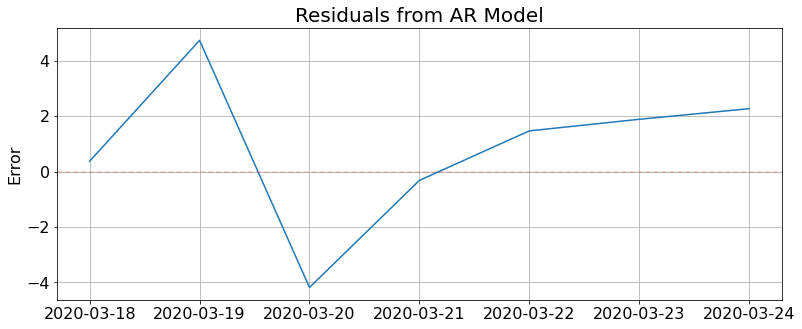

In [78]:
plt.figure(figsize=(13,5))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)
plt.grid(True)

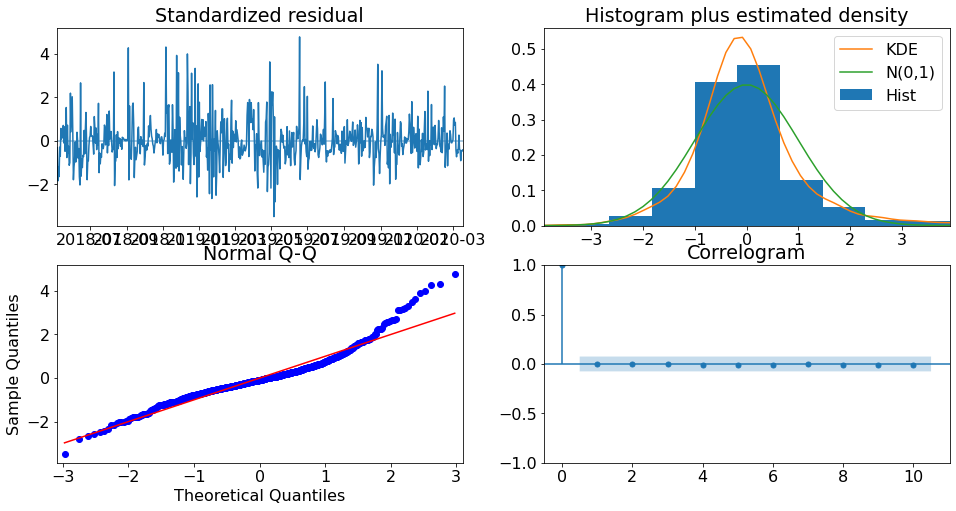

In [86]:
ar_model.plot_diagnostics(figsize=(16, 8))
plt.show()

In [79]:
perform_adf_test(residuals)

ADF Statistic: -2.730608
p-value: 0.068890


### 14. Making 1 Day Ahead Predictions

In [80]:
forecast2_AR = copy.deepcopy(forecast)
forecast2_AR[0] = forecast2_AR[0] + data[-9]
for i in range(1,len(forecast2_AR)):
    forecast2_AR[i] = forecast2_AR[i] + valid_AR[i-1]
forecast2_AR

2020-03-18    27.207697
2020-03-19    26.176869
2020-03-20    31.033912
2020-03-21    26.270499
2020-03-22    26.263248
2020-03-23    28.215978
2020-03-24    30.132443
Freq: D, dtype: float64

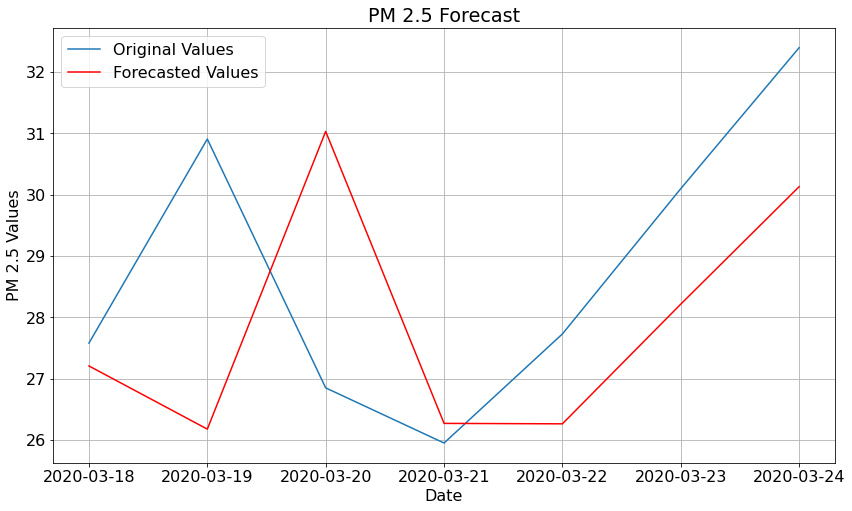

In [81]:
#plotting the results
plt.plot(figsize=(10,5))
plt.plot(valid_AR, label='Original Values')
plt.plot(forecast2_AR, color='red', label='Forecasted Values')
plt.xlabel('Date')
plt.ylabel('PM 2.5 Values')
plt.title('PM 2.5 Forecast')
plt.grid(True)
plt.legend()

In [82]:
#Calculating RMS Error
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(valid_AR, forecast2_AR))
rms

2.6989866317435016

In [83]:
#Calculating MAPE
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape
MAPE(valid_AR,forecast2_AR)

7.432482420664739

### 15. Using a Prediction Equation

In [100]:
forecast3_AR = copy.deepcopy(valid)
for i in range(0,7):
    forecast3_AR[i] = 0
    for j in range(1,13):
        forecast3_AR[i] +=  coef[j]*(data['Diff1'][-7+i-j])
forecast3_AR

From Date
2020-03-18    5.956872
2020-03-19   -1.432672
2020-03-20   -2.755546
2020-03-21   -0.107328
2020-03-22    0.932677
2020-03-23   -0.297451
2020-03-24   -1.287159
Name: PM2.5, dtype: float64

In [95]:
coef = ar_model.params
coef

intercept   -0.199175
PM2.5.L1    -0.614326
PM2.5.L2    -0.459162
PM2.5.L3    -0.333102
PM2.5.L4    -0.325310
PM2.5.L5    -0.221961
PM2.5.L6    -0.282432
PM2.5.L7    -0.163672
PM2.5.L8    -0.214368
PM2.5.L9    -0.200000
PM2.5.L10   -0.207320
PM2.5.L11   -0.152233
PM2.5.L12   -0.125277
dtype: float64

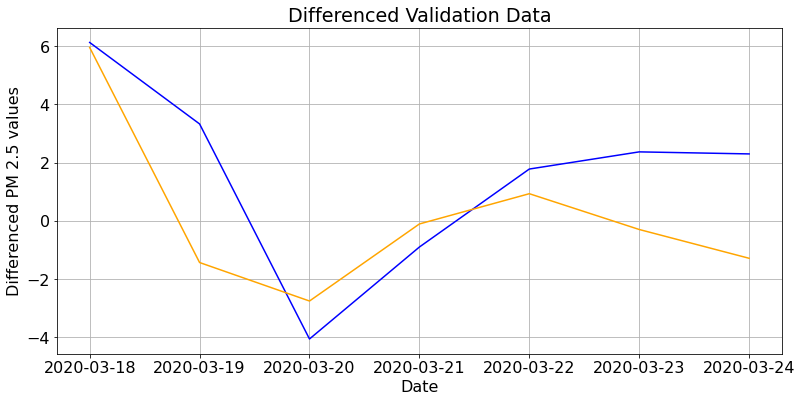

In [101]:
#Plotting the validation data
plt.figure(figsize = (13,6))
plt.plot(valid, label ='Valid', color = 'b')
plt.plot(forecast3_AR,label = 'Forecast', color = 'orange')
plt.xlabel('Date')
plt.ylabel('Differenced PM 2.5 values')
plt.title('Differenced Validation Data')
plt.grid(True)

In [104]:
#converting forecasts to Oiginal Scale
forecasst3_AR = copy.deepcopy(forecast3_AR)
s1 = forecasst3_AR.cumsum()
s1 = s1 + data[-9]
s1

From Date
2020-03-18    27.406872
2020-03-19    25.974201
2020-03-20    23.218655
2020-03-21    23.111327
2020-03-22    24.044004
2020-03-23    23.746553
2020-03-24    22.459394
Name: PM2.5, dtype: float64

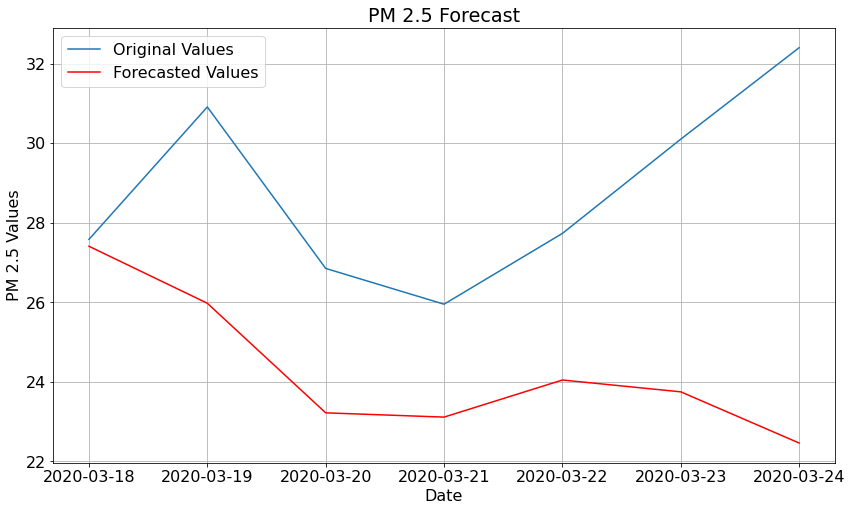

In [106]:
#plotting the results
plt.plot(figsize=(10,5))
plt.plot(valid_AR, label='Original Values')
plt.plot(s1, color='red', label='Forecasted Values')
plt.xlabel('Date')
plt.ylabel('PM 2.5 Values')
plt.title('PM 2.5 Forecast')
plt.grid(True)
plt.legend()

In [178]:
rms = sqrt(mean_squared_error(valid_AR, s1))
rms

5.32387243012774

In [179]:
MAPE(valid_AR, s1)

15.162960453759691

In [107]:
forecast4_AR = copy.deepcopy(forecast3_AR)
forecast4_AR[0] = forecast4_AR[0] + data[-9]
for i in range(1,len(forecast4_AR)):
    forecast4_AR[i] = forecast4_AR[i] + valid_AR[i-1]
forecast4_AR

From Date
2020-03-18    27.406872
2020-03-19    26.147328
2020-03-20    28.154454
2020-03-21    26.742672
2020-03-22    26.882677
2020-03-23    27.432549
2020-03-24    28.812841
Name: PM2.5, dtype: float64

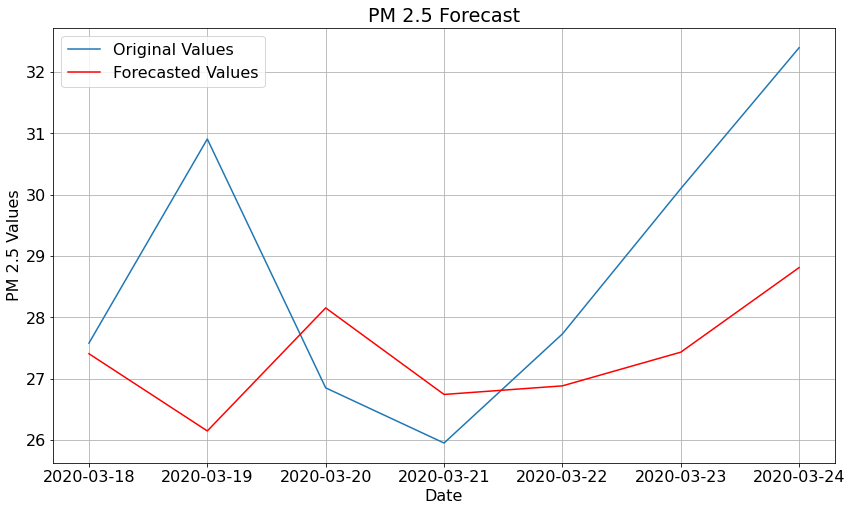

In [108]:
#plotting the results
plt.plot(figsize=(10,5))
plt.plot(valid_AR, label='Original Values')
plt.plot(forecast4_AR, color='red', label='Forecasted Values')
plt.xlabel('Date')
plt.ylabel('PM 2.5 Values')
plt.title('PM 2.5 Forecast')
plt.grid(True)
plt.legend()

In [109]:
#Calculating RMS Error
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(valid_AR, forecast4_AR))
rms

2.556333919391165

In [110]:
#Calculating MAPE
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape
MAPE(valid_AR,forecast4_AR)

6.70541341167422

## MA Model

### 1. Fitting the MA Model

In [112]:
#FInding the best model parameters using AIC criteria
from statsmodels.tsa.arima_model import ARIMA
for _ in range(1,20):
    MA_model = ARIMA(train, order=(0,0,_)).fit()
    # MA_model.aic
    print("Lag = %f AIC = %f"%(_,MA_model.aic))

Lag = 1.000000 AIC = 5529.904670
Lag = 2.000000 AIC = 5519.421275
Lag = 3.000000 AIC = 5516.100694
Lag = 4.000000 AIC = 5510.478523
Lag = 5.000000 AIC = 5512.398910
Lag = 6.000000 AIC = 5509.466436
Lag = 7.000000 AIC = 5509.751655
Lag = 8.000000 AIC = 5505.845005
Lag = 9.000000 AIC = 5507.797669
Lag = 10.000000 AIC = 5509.547163
Lag = 11.000000 AIC = 5511.028299
Lag = 12.000000 AIC = 5511.558029
Lag = 13.000000 AIC = 5511.926549
Lag = 14.000000 AIC = 5513.782184
Lag = 15.000000 AIC = 5515.778798
Lag = 16.000000 AIC = 5516.957264
Lag = 17.000000 AIC = 5518.755831
Lag = 18.000000 AIC = 5520.006630
Lag = 19.000000 AIC = 5518.722716


In [113]:
#The lowest AIC score is for lag = 8 . So we choose lag = 8 
MA_model = ARIMA(train, order = (0,0,8)).fit()
print(MA_model.summary())

                              ARMA Model Results                              
Dep. Variable:                  PM2.5   No. Observations:                  693
Model:                     ARMA(0, 8)   Log Likelihood               -2742.923
Method:                       css-mle   S.D. of innovations             12.658
Date:                Wed, 29 Sep 2021   AIC                           5505.845
Time:                        11:34:02   BIC                           5551.255
Sample:                    04-25-2018   HQIC                          5523.407
                         - 03-17-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0240      0.073     -0.327      0.744      -0.168       0.120
ma.L1.PM2.5    -0.6180      0.038    -16.360      0.000      -0.692      -0.544
ma.L2.PM2.5    -0.0962      0.044     -2.173    

In [115]:
ma_coef = MA_model.params
ma_coef

const         -0.023991
ma.L1.PM2.5   -0.618018
ma.L2.PM2.5   -0.096224
ma.L3.PM2.5    0.003603
ma.L4.PM2.5   -0.083443
ma.L5.PM2.5    0.042193
ma.L6.PM2.5   -0.114809
ma.L7.PM2.5    0.108594
ma.L8.PM2.5   -0.091467
dtype: float64

In [117]:
pvals = MA_model.pvalues

In [118]:
for i in range(len(ma_coef)):
    if pvals[i] > 0.05:
        ma_coef[i] = 0

In [119]:
ma_coef

const          0.000000
ma.L1.PM2.5   -0.618018
ma.L2.PM2.5   -0.096224
ma.L3.PM2.5    0.000000
ma.L4.PM2.5    0.000000
ma.L5.PM2.5    0.000000
ma.L6.PM2.5   -0.114809
ma.L7.PM2.5    0.108594
ma.L8.PM2.5   -0.091467
dtype: float64

### 2. Making 7 day forecast

In [120]:
#Making 7 Day forecast
ma_forecast = MA_model.predict(start = len(train), end = len(train)+6)
ma_forecast

2020-03-18    3.607809
2020-03-19   -0.049195
2020-03-20    1.210110
2020-03-21   -0.204235
2020-03-22    0.877046
2020-03-23    0.428066
2020-03-24    0.000000
Freq: D, dtype: float64

In [121]:
valid

From Date
2020-03-18    6.13
2020-03-19    3.33
2020-03-20   -4.06
2020-03-21   -0.90
2020-03-22    1.78
2020-03-23    2.37
2020-03-24    2.30
Name: PM2.5, dtype: float64

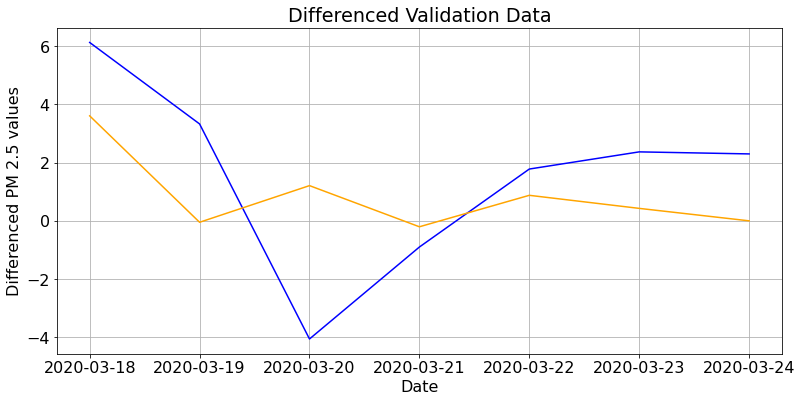

In [122]:
#Plotting the validation data
plt.figure(figsize = (13,6))
plt.plot(valid, label ='Valid', color = 'b')
plt.plot(ma_forecast,label = 'Forecast', color = 'orange')
plt.xlabel('Date')
plt.ylabel('Differenced PM 2.5 values')
plt.title('Differenced Validation Data')
plt.grid(True)

In [123]:
#converting forecasts to Oiginal Scale
forecast_MA = copy.deepcopy(ma_forecast)
MA = forecast_MA.cumsum()
MA = MA + data[-9]
MA

2020-03-18    25.057809
2020-03-19    25.008614
2020-03-20    26.218723
2020-03-21    26.014488
2020-03-22    26.891534
2020-03-23    27.319600
2020-03-24    27.319600
Freq: D, dtype: float64

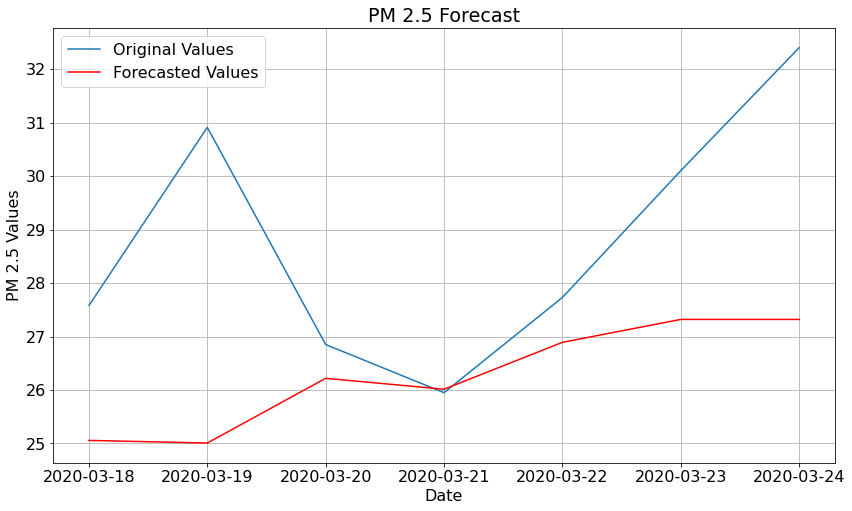

In [124]:
#plotting the results
plt.plot(figsize=(10,5))
plt.plot(valid_AR, label='Original Values')
plt.plot(MA, color='red', label='Forecasted Values')
plt.xlabel('Date')
plt.ylabel('PM 2.5 Values')
plt.title('PM 2.5 Forecast')
plt.grid(True)
plt.legend()

### 3. Checking forecast Accuracy

In [125]:
#Calculating RMS Error
rms = sqrt(mean_squared_error(valid_AR, MA))
rms

3.2914302087609135

In [126]:
MAPE(valid_AR,MA)

8.396846544344069

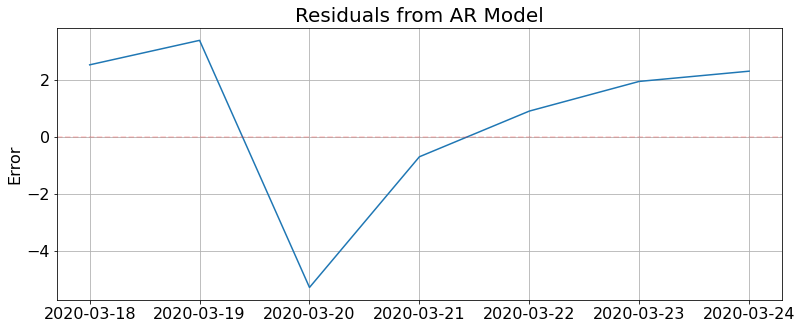

In [127]:
residuals = valid - ma_forecast
plt.figure(figsize=(13,5))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)
plt.grid(True)

### 4. Making 1 DAY MA predictions

In [129]:
forecast_MA[0] = forecast_MA[0] + data[-9]
for i in range(1,len(forecast_MA)):
    forecast_MA[i] = forecast_MA[i] + valid_AR[i-1]
forecast_MA

2020-03-18    25.057809
2020-03-19    27.530805
2020-03-20    32.120110
2020-03-21    26.645765
2020-03-22    26.827046
2020-03-23    28.158066
2020-03-24    30.100000
Freq: D, dtype: float64

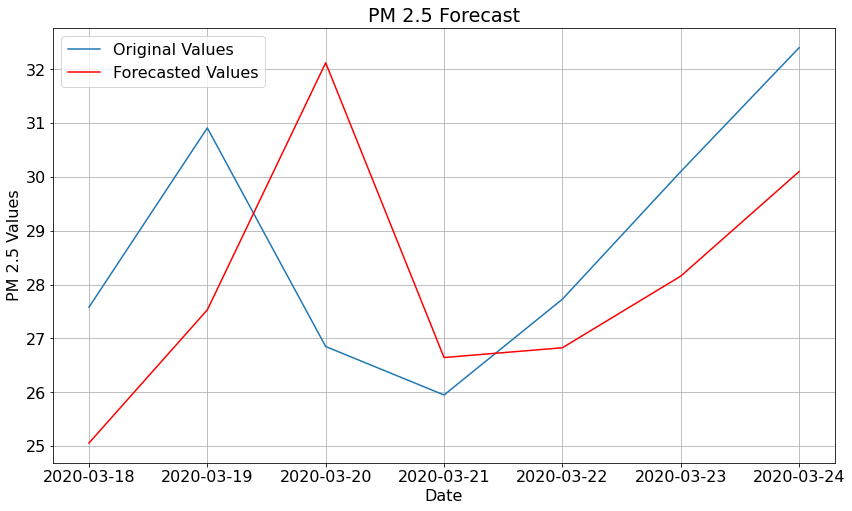

In [130]:
#plotting the results
plt.plot(figsize=(10,5))
plt.plot(valid_AR, label='Original Values')
plt.plot(forecast_MA, color='red', label='Forecasted Values')
plt.xlabel('Date')
plt.ylabel('PM 2.5 Values')
plt.title('PM 2.5 Forecast')
plt.grid(True)
plt.legend()

In [131]:
#Calculating RMS Error
rms = sqrt(mean_squared_error(valid_AR,forecast_MA ))
rms

2.8262794512500267

In [132]:
MAPE(valid_AR, forecast_MA)

8.456160401969374

### 5. Using MA Equation

In [133]:
forecast2_MA = copy.deepcopy(valid)
for i in range(0,7):
    forecast2_MA[i] = 0
    for j in range(1,9):
        forecast2_MA[i] +=  ma_coef[j]*(data['Diff1'][-7+i-j])
forecast2_MA

From Date
2020-03-18    1.481113
2020-03-19   -4.584527
2020-03-20   -1.541923
2020-03-21    1.218588
2020-03-22    1.909711
2020-03-23   -1.186213
2020-03-24   -2.481120
Name: PM2.5, dtype: float64

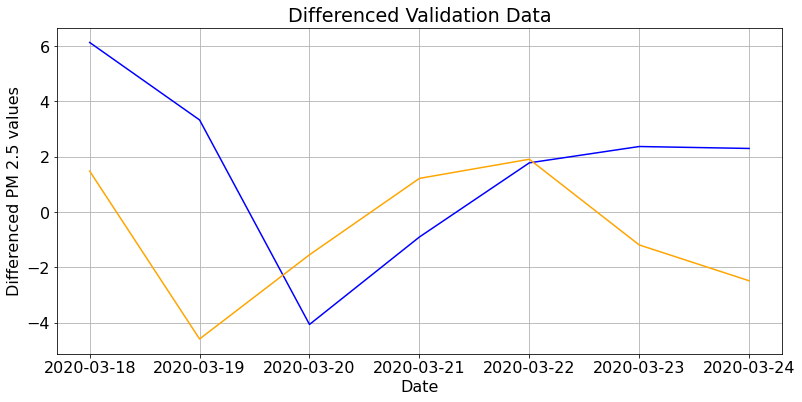

In [134]:
#Plotting the validation data
plt.figure(figsize = (13,6))
plt.plot(valid, label ='Valid', color = 'b')
plt.plot(forecast2_MA,label = 'Forecast', color = 'orange')
plt.xlabel('Date')
plt.ylabel('Differenced PM 2.5 values')
plt.title('Differenced Validation Data')
plt.grid(True)

In [135]:
#converting forecasts to Oiginal Scale
forecast3_MA = copy.deepcopy(forecast2_MA)
MA2 = forecast3_MA.cumsum()
MA2 = MA2 + data[-9]
MA2

From Date
2020-03-18    22.931113
2020-03-19    18.346586
2020-03-20    16.804663
2020-03-21    18.023252
2020-03-22    19.932962
2020-03-23    18.746749
2020-03-24    16.265629
Name: PM2.5, dtype: float64

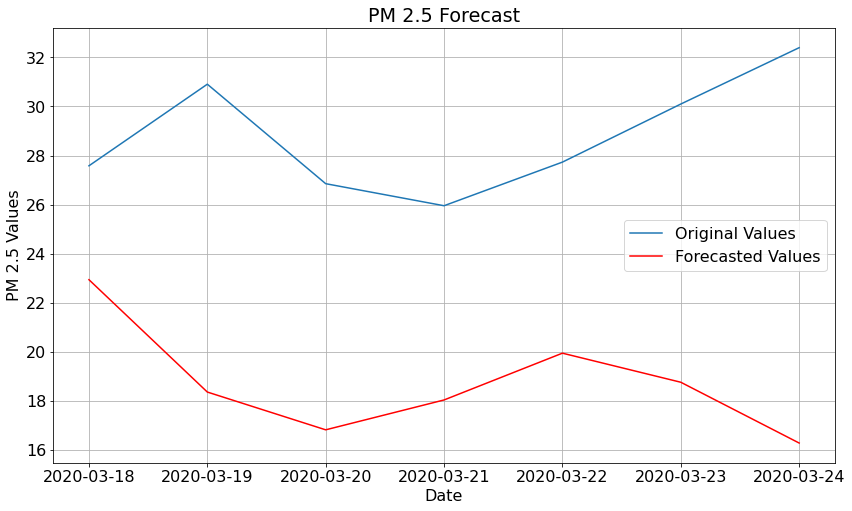

In [136]:
#plotting the results
plt.plot(figsize=(10,5))
plt.plot(valid_AR, label='Original Values')
plt.plot(MA2, color='red', label='Forecasted Values')
plt.xlabel('Date')
plt.ylabel('PM 2.5 Values')
plt.title('PM 2.5 Forecast')
plt.grid(True)
plt.legend()

In [137]:
#Calculating RMS Error
rms = sqrt(mean_squared_error(valid_AR,MA2 ))
rms

10.644929478237966

In [138]:
MAPE(valid_AR, MA2)

34.44196679159221

In [180]:
forecast4_MA = copy.deepcopy(forecast2_MA)
forecast4_MA[0] = forecast4_MA[0] + data[-9]
for i in range(1,len(forecast4_MA)):
    forecast4_MA[i] = forecast4_MA[i] + valid_AR[i-1]
forecast4_MA

From Date
2020-03-18    22.931113
2020-03-19    22.995473
2020-03-20    29.368077
2020-03-21    28.068588
2020-03-22    27.859711
2020-03-23    26.543787
2020-03-24    27.618880
Name: PM2.5, dtype: float64

In [181]:
#Calculating RMS Error
rms = sqrt(mean_squared_error(valid_AR, forecast4_MA))
rms

4.319450966119557

In [182]:
MAPE(valid_AR, forecast4_MA)

12.434639261202848

In [139]:
import itertools
p =  range(0, 10)
q = range(0, 10)
d = range(0,2)
pdq = list(itertools.product(p, d, q))
print('Some parameter combinations for the Model...')
for i in range(1,len(pdq)):
    print('Model: {}'.format(pdq[i]))

Some parameter combinations for the Model...
Model: (0, 0, 1)
Model: (0, 0, 2)
Model: (0, 0, 3)
Model: (0, 0, 4)
Model: (0, 0, 5)
Model: (0, 0, 6)
Model: (0, 0, 7)
Model: (0, 0, 8)
Model: (0, 0, 9)
Model: (0, 1, 0)
Model: (0, 1, 1)
Model: (0, 1, 2)
Model: (0, 1, 3)
Model: (0, 1, 4)
Model: (0, 1, 5)
Model: (0, 1, 6)
Model: (0, 1, 7)
Model: (0, 1, 8)
Model: (0, 1, 9)
Model: (1, 0, 0)
Model: (1, 0, 1)
Model: (1, 0, 2)
Model: (1, 0, 3)
Model: (1, 0, 4)
Model: (1, 0, 5)
Model: (1, 0, 6)
Model: (1, 0, 7)
Model: (1, 0, 8)
Model: (1, 0, 9)
Model: (1, 1, 0)
Model: (1, 1, 1)
Model: (1, 1, 2)
Model: (1, 1, 3)
Model: (1, 1, 4)
Model: (1, 1, 5)
Model: (1, 1, 6)
Model: (1, 1, 7)
Model: (1, 1, 8)
Model: (1, 1, 9)
Model: (2, 0, 0)
Model: (2, 0, 1)
Model: (2, 0, 2)
Model: (2, 0, 3)
Model: (2, 0, 4)
Model: (2, 0, 5)
Model: (2, 0, 6)
Model: (2, 0, 7)
Model: (2, 0, 8)
Model: (2, 0, 9)
Model: (2, 1, 0)
Model: (2, 1, 1)
Model: (2, 1, 2)
Model: (2, 1, 3)
Model: (2, 1, 4)
Model: (2, 1, 5)
Model: (2, 1, 6)
Mod

In [141]:
ARIMA_train = train.copy()
ARIMA_test = valid.copy()

In [150]:
# Creating an empty Dataframe with column names only
ARIMA_AIC = pd.DataFrame(columns=['param', 'AIC'])
ARIMA_AIC

,param,AIC


In [151]:
 # Let's start by building ARIMA model -- 
from statsmodels.tsa.arima_model import ARIMA
best_aic = 10000
for param in pdq:
    try:
        ARIMA_model = ARIMA(ARIMA_train,order=param).fit()
        if (ARIMA_model.aic < best_aic):
            best_aic = ARIMA_model.aic
            best_param = param
        ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)
    except:
        continue
print('best_param =', best_param, 'best_aic =', best_aic)

best_param = (9, 1, 9) best_aic = 5503.546331273385


In [152]:
best_param

(5, 0, 4)

In [153]:
best_aic

5503.546331273385

In [155]:
ARIMA_model = ARIMA(ARIMA_train,order=best_param).fit()
print(ARIMA_model.summary())

                              ARMA Model Results                              
Dep. Variable:                  PM2.5   No. Observations:                  693
Model:                     ARMA(5, 4)   Log Likelihood               -2740.773
Method:                       css-mle   S.D. of innovations             12.583
Date:                Wed, 29 Sep 2021   AIC                           5503.546
Time:                        12:43:23   BIC                           5553.498
Sample:                    04-25-2018   HQIC                          5522.864
                         - 03-17-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0247      0.076     -0.324      0.746      -0.174       0.124
ar.L1.PM2.5    -1.0967      0.076    -14.363      0.000      -1.246      -0.947
ar.L2.PM2.5    -0.9466      0.076    -12.477    

(-100.0, 100.0)

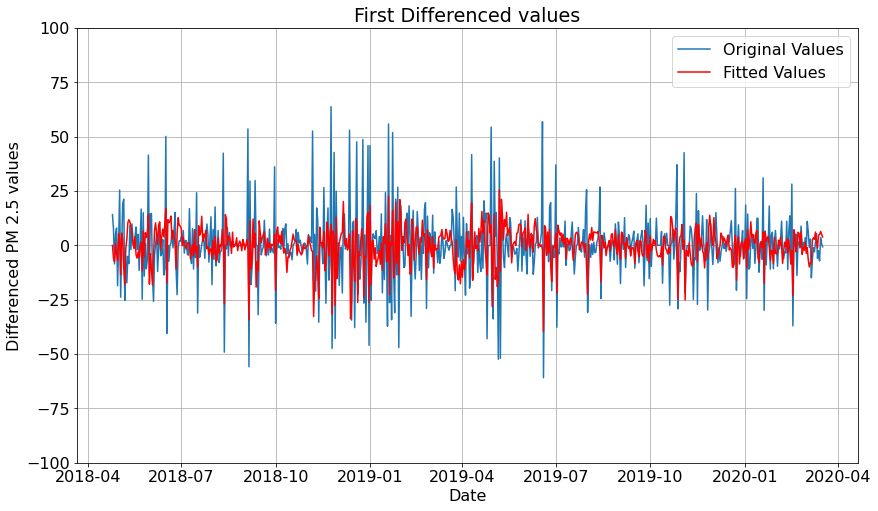

In [156]:
#visualizing the fitted values 
plt.plot(train, label='Original Values')
plt.plot(ARIMA_model.fittedvalues, color='red', label='Fitted Values')
plt.xlabel('Date')
plt.ylabel('Differenced PM 2.5 values')
plt.title('First Differenced values')
plt.grid(True)
plt.legend()
plt.ylim((-100,100))

In [157]:
#Making 7 Day forecast
ARIMA_forecast = ARIMA_model.predict(start = len(train), end = len(train)+6)
ARIMA_forecast

2020-03-18    3.418490
2020-03-19    0.353921
2020-03-20    2.983826
2020-03-21   -1.037788
2020-03-22   -0.506770
2020-03-23    1.577713
2020-03-24    0.221173
Freq: D, dtype: float64

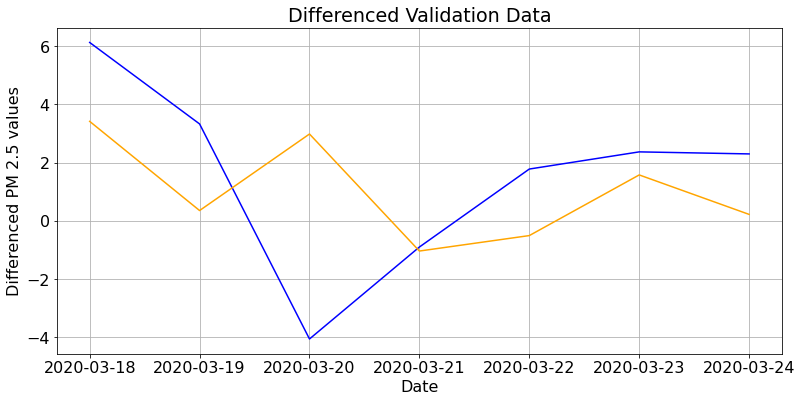

In [158]:
#Plotting the validation data
plt.figure(figsize = (13,6))
plt.plot(valid, label ='Valid', color = 'b')
plt.plot(ARIMA_forecast,label = 'Forecast', color = 'orange')
plt.xlabel('Date')
plt.ylabel('Differenced PM 2.5 values')
plt.title('Differenced Validation Data')
plt.grid(True)

In [159]:
#converting forecasts to Oiginal Scale
arima = ARIMA_forecast.cumsum()
arima = arima + data[-9]
arima

2020-03-18    24.868490
2020-03-19    25.222411
2020-03-20    28.206237
2020-03-21    27.168449
2020-03-22    26.661679
2020-03-23    28.239392
2020-03-24    28.460566
Freq: D, dtype: float64

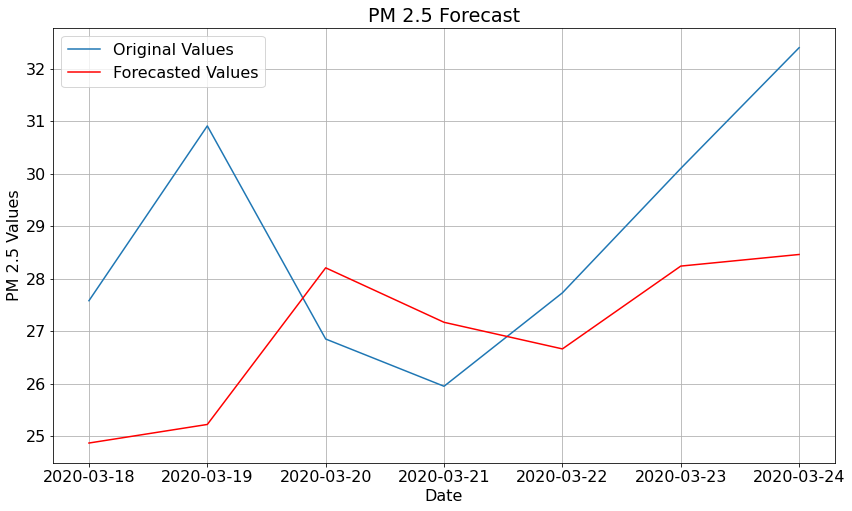

In [160]:
#plotting the results
plt.plot(figsize=(10,5))
plt.plot(valid_AR, label='Original Values')
plt.plot(arima, color='red', label='Forecasted Values')
plt.xlabel('Date')
plt.ylabel('PM 2.5 Values')
plt.title('PM 2.5 Forecast')
plt.grid(True)
plt.legend()

In [161]:
rms = sqrt(mean_squared_error(valid_AR, arima))
rms

3.0035043201286467

In [162]:
MAPE(valid_AR, arima)

8.595886212129157

In [164]:
residuals = valid - ARIMA_forecast

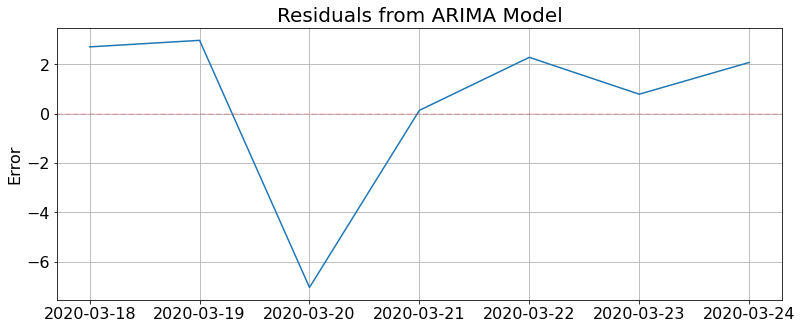

In [166]:
plt.figure(figsize=(13,5))
plt.plot(residuals)
plt.title('Residuals from ARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)
plt.grid(True)

In [167]:
forecast2_ARIMA = copy.deepcopy(ARIMA_forecast)
forecast2_ARIMA[0] = forecast2_ARIMA[0] + data[-9]
for i in range(1,len(forecast2_ARIMA)):
    forecast2_ARIMA[i] = forecast2_ARIMA[i] + valid_AR[i-1]
forecast2_ARIMA

2020-03-18    24.868490
2020-03-19    27.933921
2020-03-20    33.893826
2020-03-21    25.812212
2020-03-22    25.443230
2020-03-23    29.307713
2020-03-24    30.321173
Freq: D, dtype: float64

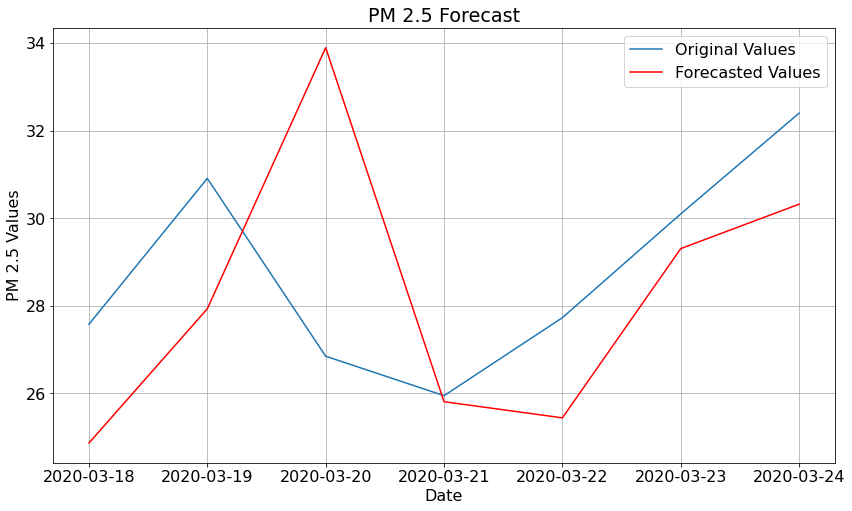

In [168]:
#plotting the results
plt.plot(figsize=(10,5))
plt.plot(valid_AR, label='Original Values')
plt.plot(forecast2_ARIMA, color='red', label='Forecasted Values')
plt.xlabel('Date')
plt.ylabel('PM 2.5 Values')
plt.title('PM 2.5 Forecast')
plt.grid(True)
plt.legend()

In [169]:
rms = sqrt(mean_squared_error(valid_AR, forecast2_ARIMA))
rms

3.295502443366001

In [170]:
MAPE(valid_AR, forecast2_ARIMA)

9.074210714273544

In [171]:
ARIMA_coef = ARIMA_model.params
ARIMA_coef

const         -0.024665
ar.L1.PM2.5   -1.096710
ar.L2.PM2.5   -0.946627
ar.L3.PM2.5   -0.213478
ar.L4.PM2.5    0.420414
ar.L5.PM2.5    0.173586
ma.L1.PM2.5    0.482575
ma.L2.PM2.5    0.192328
ma.L3.PM2.5   -0.482487
ma.L4.PM2.5   -0.774251
dtype: float64

In [175]:
#Using Equation 
forecast3_ARIMA = copy.deepcopy(valid)
for i in range(0,7):
    forecast3_ARIMA[i] = 0
    for j in range(1,6):
        forecast3_ARIMA[i] +=  ARIMA_coef[j]*(data['Diff1'][-7+i-j])
    for k in range(6,10):
        forecast3_ARIMA[i] +=  ARIMA_coef[k]*(data['Diff1'][-7+i-k+5])
forecast3_ARIMA

From Date
2020-03-18   -0.561919
2020-03-19   -6.306737
2020-03-20   -5.839624
2020-03-21   -3.917430
2020-03-22   -0.987708
2020-03-23    2.297128
2020-03-24   -0.157166
Name: PM2.5, dtype: float64

From Date
2020-03-17   -0.67
2020-03-18    6.13
2020-03-19    3.33
2020-03-20   -4.06
2020-03-21   -0.90
2020-03-22    1.78
2020-03-23    2.37
2020-03-24    2.30
Name: PM2.5, dtype: float64

In [176]:
ARIMA_coef

const         -0.024665
ar.L1.PM2.5   -1.096710
ar.L2.PM2.5   -0.946627
ar.L3.PM2.5   -0.213478
ar.L4.PM2.5    0.420414
ar.L5.PM2.5    0.173586
ma.L1.PM2.5    0.482575
ma.L2.PM2.5    0.192328
ma.L3.PM2.5   -0.482487
ma.L4.PM2.5   -0.774251
dtype: float64

In [177]:
#converting forecasts to Oiginal Scale
arima2 = forecast3_ARIMA.cumsum()
arima2 = arima2 + data[-9]
arima2

From Date
2020-03-18    20.888081
2020-03-19    14.581343
2020-03-20     8.741720
2020-03-21     4.824290
2020-03-22     3.836582
2020-03-23     6.133709
2020-03-24     5.976543
Name: PM2.5, dtype: float64